In [ ]:
import pandas as pd
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# Set random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Prepare data for two targets simultaneously
def prepare_data(device, path, n_samples=500, test_size=0.2, recal_size=0.2, batch_size=32, seed=5, bootstrap=False):
    set_seed(seed)
    data = pd.read_excel(path)

    if bootstrap:
        data = data.sample(n=n_samples, replace=True, random_state=seed)
    else:
        data = data.sample(n=n_samples, random_state=seed)

    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values  # BOTH TARGETS

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    recal_split = recal_size / (1 - test_size)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_split, random_state=seed)

    # Tensors
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_recal, y_recal = torch.tensor(X_recal).float(), torch.tensor(y_recal).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
    
    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)

    X_train = (X_train - mean_X) / std_X
    X_recal = (X_recal - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X

    y_train = (y_train - mean_y) / std_y
    y_recal = (y_recal - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y

    # Device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_recal, y_recal = X_recal.to(device), y_recal.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    recal_loader = DataLoader(TensorDataset(X_recal, y_recal), batch_size=batch_size, shuffle=False)

    return X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y

# Training
set_seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "synthetic_data.xlsx"
X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y = prepare_data(device, file_path, n_samples = 400)

FileNotFoundError: [Errno 2] No such file or directory: 'synthetic_data.xlsx'

In [ ]:
import torch.distributions as D

# Bayesian Linear Layer
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, rho_init):
        super().__init__()
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.ones(out_features, in_features) * rho_init)
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(torch.ones(out_features) * rho_init)
        self.prior = Normal(0, 1)

    def forward(self, x):
        weight = Normal(self.weight_mu, F.softplus(self.weight_rho)).rsample()
        bias = Normal(self.bias_mu, F.softplus(self.bias_rho)).rsample()
        return F.linear(x, weight, bias)

    def kl_divergence(self):
        weight_post = Normal(self.weight_mu, F.softplus(self.weight_rho))
        bias_post = Normal(self.bias_mu, F.softplus(self.bias_rho))
        kl_weight = torch.distributions.kl.kl_divergence(weight_post, self.prior).sum()
        kl_bias = torch.distributions.kl.kl_divergence(bias_post, self.prior).sum()
        return kl_weight + kl_bias

# Multi-output Bayesian NN
class MultiOutputBNN(nn.Module):
    def __init__(self, input_size, n_hidden, rho_init):
        super().__init__()
        self.fc1 = BayesianLinear(input_size, n_hidden, rho_init)
        self.fc2 = BayesianLinear(n_hidden, n_hidden, rho_init)
        self.fc_mean = BayesianLinear(n_hidden, 2, rho_init)
        self.fc_cov = BayesianLinear(n_hidden, 3, rho_init)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)                  # (batch, 2)
        cov_params = self.fc_cov(x)             # (batch, 3)
        
        # Clamp the log-variance to avoid extreme values if needed
        #log_var = torch.clamp(cov_params[:, :2], min=-10, max=10)
        log_var = cov_params[:, :2]
        # Optionally, restrict rho to avoid extreme correlations:
        rho = 0.99 * torch.tanh(cov_params[:, 2])
        
        std = torch.exp(0.5 * log_var)
        cov12 = rho * std[:, 0] * std[:, 1]
        
        # Construct covariance matrix
        cov_matrix = torch.zeros(x.size(0), 2, 2, device=x.device)
        cov_matrix[:, 0, 0] = std[:, 0]**2
        cov_matrix[:, 1, 1] = std[:, 1]**2
        cov_matrix[:, 0, 1] = cov12
        cov_matrix[:, 1, 0] = cov12
        return mean, cov_matrix

    def kl_divergence(self):
        return sum(layer.kl_divergence() for layer in [self.fc1, self.fc2, self.fc_mean, self.fc_cov])
    
# Loss Function

def multi_output_loss(mean, cov_matrix, y_true, kl_div, kl_weight):
    eps = 1e-3  # Increase epsilon to help ensure PD
    eye = torch.eye(2, device=cov_matrix.device).unsqueeze(0)
    cov_pd = cov_matrix + eps * eye
    dist = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov_pd)
    nll = -dist.log_prob(y_true).mean()
    return nll + kl_weight * kl_div


model = MultiOutputBNN(X_train.shape[1], n_hidden=32, rho_init=-3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=8.629e-04)

loss_history = []
kl_weight = 1.0e-03

epochs = 5000
for epoch in range(1, epochs+1):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        mean, cov_matrix = model(X_batch)            
        kl = model.kl_divergence()
        loss = multi_output_loss(mean, cov_matrix, y_batch, kl, kl_weight)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)
    if epoch % 1000 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}")

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/5000, Loss: 57.0054


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm

# MC Predictions & Evaluation (joint output)
def mc_predict_with_uncertainty(model, X, n_samples, device):
    all_means, all_covs = [], []
    X = X.to(device)
    with torch.no_grad():
        for _ in range(n_samples):
            mean, cov = model(X)
            all_means.append(mean.cpu().numpy())           # (batch,2)
            all_covs.append(cov.cpu().numpy())             # (batch,2,2)
    return np.stack(all_means), np.stack(all_covs)      # shapes: (MC,batch,2), (MC,batch,2,2)

def calculate_uncertainties(mc_means, mc_covs):
    epistemic = np.var(mc_means, axis=0)                                # (batch,2)
    # Extract shape (MC, batch_size, 2) of diagonals
    diag = np.diagonal(mc_covs, axis1=2, axis2=3)

    # Average over MC dimension → (batch_size, 2)
    aleatoric = diag.mean(axis=0)
    total     = epistemic + aleatoric                                  # (batch,2)
    return epistemic, aleatoric, total

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def calc_interval_picp(y_true, y_pred, total_unc, confidence=0.80):
    z = norm.ppf((1+confidence)/2)
    lower = y_pred - z*np.sqrt(total_unc)
    upper = y_pred + z*np.sqrt(total_unc)
    picp = np.mean((y_true >= lower) & (y_true <= upper)) * 100
    return lower, upper, picp

# Run MC for Train, Test, Recal
n_mc = 300
train_means, train_covs = mc_predict_with_uncertainty(model, X_train, n_mc, device)
test_means,  test_covs  = mc_predict_with_uncertainty(model, X_test,  n_mc, device)
recal_means, recal_covs = mc_predict_with_uncertainty(model, X_recal, n_mc, device)

# Compute point predictions
train_pred = train_means.mean(axis=0)
test_pred  = test_means.mean(axis=0)
recal_pred = recal_means.mean(axis=0)

# Convert true values
y_train_np, y_test_np, y_recal_np = y_train.cpu().numpy(), y_test.cpu().numpy(), y_recal.cpu().numpy()

# Compute uncertainties
train_epi, train_ale, train_tot = calculate_uncertainties(train_means, train_covs)
test_epi,  test_ale,  test_tot  = calculate_uncertainties(test_means,  test_covs)
recal_epi, recal_ale, recal_tot = calculate_uncertainties(recal_means, recal_covs)

print('Number of samples:')
print(len(y_train) + len(y_test) + len(y_recal))

for name, pred, y_true, tot_unc, epi, ale in [
    ('Train', train_pred, y_train_np, train_tot, train_epi, train_ale),
    ('Test',  test_pred,  y_test_np,  test_tot,  test_epi,  test_ale)
]:
    print(f"\n{name} Set Metrics:")
    for idx, target_label in enumerate(['Measured voltage', 'Predicted voltage']):
        mae, mse, rmse, r2 = evaluate_model(y_true[:, idx], pred[:, idx])
        lb, ub, picp = calc_interval_picp(y_true[:, idx], pred[:, idx], tot_unc[:, idx], confidence=0.80)
        epi_mean = epi[:, idx].mean()
        ale_mean = ale[:, idx].mean()

        print(f"  {target_label}:")
        print(f"    MAE:            {mae:.4f}")
        print(f"    RMSE:           {rmse:.4f}")
        print(f"    R²:             {r2:.4f}")
        print(f"    PICP (80%):     {picp:.2f}%")
        print(f"    Epistemic (μ):  {epi_mean:.4f}")
        print(f"    Aleatoric (μ):  {ale_mean:.4f}")




Number of samples:
400

Train Set Metrics:
  Measured voltage:
    MAE:            0.0159
    RMSE:           0.0321
    R²:             0.9990
    PICP (80%):     75.42%
    Epistemic (μ):  0.0004
    Aleatoric (μ):  0.0026
  Predicted voltage:
    MAE:            0.3332
    RMSE:           0.4472
    R²:             0.7991
    PICP (80%):     85.83%
    Epistemic (μ):  0.0131
    Aleatoric (μ):  0.2282

Test Set Metrics:
  Measured voltage:
    MAE:            0.0315
    RMSE:           0.0535
    R²:             0.9971
    PICP (80%):     57.50%
    Epistemic (μ):  0.0004
    Aleatoric (μ):  0.0019
  Predicted voltage:
    MAE:            0.4747
    RMSE:           0.6006
    R²:             0.6260
    PICP (80%):     62.50%
    Epistemic (μ):  0.0124
    Aleatoric (μ):  0.2421


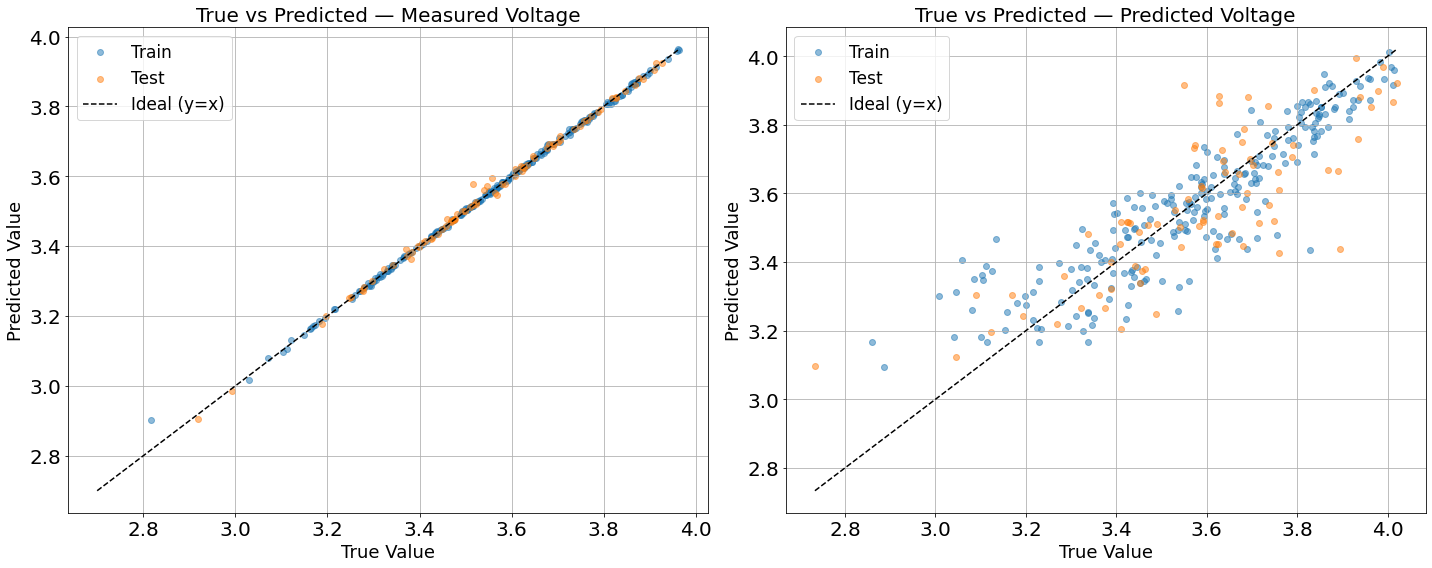

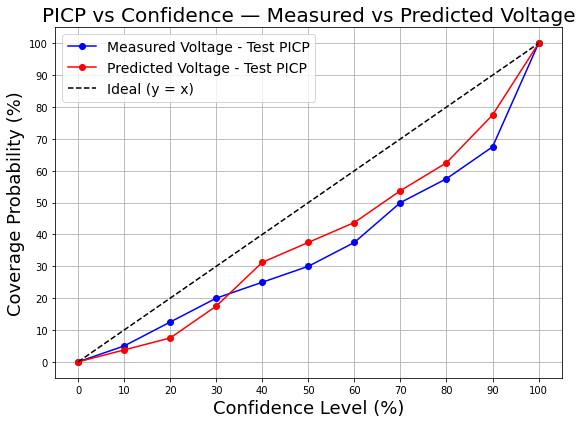

In [ ]:
# -------------------------------
# 8. De-normalization and Scatter Plot
# -------------------------------

def de_normalize(data, mean, std):
    mean_np = mean.cpu().numpy() if isinstance(mean, torch.Tensor) else mean
    std_np  = std.cpu().numpy()  if isinstance(std, torch.Tensor) else std
    return data * std_np + mean_np

# Denormalize predictions + ground truth
train_preds_denorm = de_normalize(train_pred, mean_y, std_y)
test_preds_denorm  = de_normalize(test_pred,  mean_y, std_y)
y_train_denorm     = de_normalize(y_train.cpu().numpy(), mean_y, std_y)
y_test_denorm      = de_normalize(y_test.cpu().numpy(),  mean_y, std_y)
num_samples = len(y_train) + len(y_test) + len(y_recal)

# Plot true vs predicted
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
target_names = ['Measured Voltage', 'Predicted Voltage']


for i, target_name in enumerate(target_names):
    ax = axes[i]
    ax.scatter(y_train_denorm[:, i], train_preds_denorm[:, i], alpha=0.5, label='Train')
    ax.scatter(y_test_denorm[:, i],  test_preds_denorm[:, i],  alpha=0.5, label='Test')

    # Diagonal line
    start = 2.7 if i == 0 else min(y_train_denorm[:, i].min(), y_test_denorm[:, i].min())
    end   = max(y_train_denorm[:, i].max(), train_preds_denorm[:, i].max(),
                y_test_denorm[:, i].max(), test_preds_denorm[:, i].max())
    ax.plot([start, end], [start, end], '--', color='black', label='Ideal (y=x)')

    # **Double-sized text**
    ax.set_xlabel('True Value',      fontsize=18)   # was ~12 → now ~24
    ax.set_ylabel('Predicted Value', fontsize=18)
    ax.set_title(
        f'True vs Predicted — {target_name}', #({num_samples} samples)',
        fontsize=20  # was ~16 → now ~32
    )
    ax.legend(fontsize=12+5)              # was ~12 → now ~24
    ax.tick_params(axis='both', labelsize=10*2)  # was ~10 → now ~20
    ax.grid(True)

plt.tight_layout()
plt.show()
# -------------------------------
# 9. PICP Plotting over Confidence Levels
# -------------------------------

confidence_levels = np.linspace(0, 1, 11)
train_picps = {1: [], 2: []}
test_picps  = {1: [], 2: []}

# Compute PICP for each confidence level
for cl in confidence_levels:
    for idx in range(2):
        _, _, picp_train = calc_interval_picp(y_train.cpu().numpy()[:, idx], train_pred[:, idx], train_tot[:, idx], cl)
        _, _, picp_test  = calc_interval_picp(y_test.cpu().numpy()[:, idx],  test_pred[:, idx],  test_tot[:, idx],  cl)

        train_picps[idx + 1].append(picp_train)
        test_picps[idx + 1].append(picp_test)

# Plot PICP vs Confidence for both Predicted and Measured Voltage
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PICP for Test set for both Predicted and Measured Voltage (target_names[0] = Measured Voltage, target_names[1] = Predicted Voltage)
ax.plot(confidence_levels * 100, test_picps[1], marker='o', label=f'Measured Voltage - Test PICP', linestyle='-', color='blue')
ax.plot(confidence_levels * 100, test_picps[2], marker='o', label=f'Predicted Voltage - Test PICP', linestyle='-', color='red')

# Plot Ideal line (y = x) for reference
ax.plot([0, 100], [0, 100], linestyle='--', label='Ideal (y = x)', color='black')

# Set plot labels and title
ax.set_xlabel('Confidence Level (%)', fontsize=18)
ax.set_ylabel('Coverage Probability (%)', fontsize=18)
ax.set_title('PICP vs Confidence — Measured vs Predicted Voltage', fontsize=20)

# Set ticks and grid
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 11))
ax.grid(True)

# Add legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()



[[ 2.9        -0.03028489]
 [-0.03028489  2.06742715]]


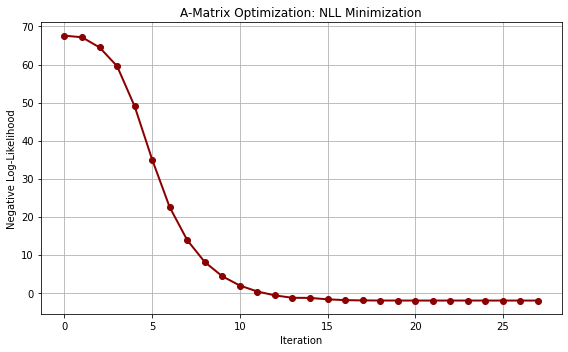

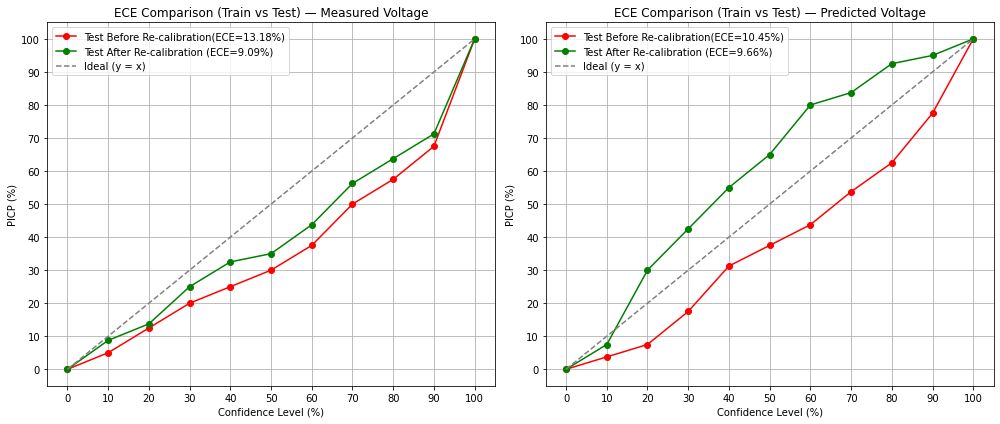

In [ ]:

from scipy.optimize import minimize

def nll_shared_offdiag(params, mu, cov, y_true):
    a, b, d = params
    A = np.array([[a, b],
                  [b, d]])

    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(mu, torch.Tensor):
        mu = mu.cpu().numpy()
    if isinstance(cov, torch.Tensor):
        cov = cov.cpu().numpy()

    if cov.ndim == 4:
        cov = cov.mean(axis=0)

    N = y_true.shape[0]
    nlls = []
    for i in range(N):
        Sigma = A @ cov[i] @ A.T
        sign, log_det = np.linalg.slogdet(Sigma)
        if sign <= 0:
            return np.inf
        diff = y_true[i] - mu[i]
        inv = np.linalg.inv(Sigma)
        nll = 0.5 * (log_det + diff.T @ inv @ diff)
        nlls.append(nll)
    return np.mean(nlls)

nll_trajectory = []
def nll_logger(params):
    nll_val = nll_shared_offdiag(params, recal_pred, recal_covs, y_recal)
    nll_trajectory.append(nll_val)
    return False



A_init_params = [1.0, 0.0, 1.0]  # [a, b, d]
result = minimize(
    nll_shared_offdiag,
    A_init_params,
    args=(recal_pred, recal_covs, y_recal),
    method='L-BFGS-B',
    callback=nll_logger
)

a_opt, b_opt, d_opt = result.x
a_opt = 2.9
A_opti = np.array([[a_opt, b_opt],
                  [b_opt, d_opt]])

print(A_opti)
# ---------- APPLY SCALING ----------
def apply_A_scaling(A, covs):
    if isinstance(covs, torch.Tensor):
        covs = covs.cpu().numpy()
    if covs.ndim == 4:
        covs = covs.mean(axis=0)

    N = covs.shape[0]
    scaled_covs = np.empty((N, 2, 2))
    for i in range(N):
        scaled_covs[i] = A @ covs[i] @ A.T
    return scaled_covs

scaled_test_covs = apply_A_scaling(A_opti, test_covs)

# ---------- PICP COMPUTATION ----------
confidence_levels = np.linspace(0, 1, 11)
train_picps = {1: [], 2: []}
test_picps = {1: [], 2: []}

for cl in confidence_levels:
    for target_idx in range(2):
        _, _, train_picp = calc_interval_picp(
            y_train.cpu().numpy()[:, target_idx],
            train_pred[:, target_idx],
            train_tot[:, target_idx],
            cl
        )
        _, _, test_picp = calc_interval_picp(
            y_test.cpu().numpy()[:, target_idx],
            test_pred[:, target_idx],
            scaled_test_covs[:, target_idx, target_idx],
            cl
        )
        train_picps[target_idx + 1].append(train_picp)
        test_picps[target_idx + 1].append(test_picp)

# ---------- PLOT NLL MINIMIZATION ----------
plt.figure(figsize=(8, 5))
plt.plot(nll_trajectory, marker='o', linewidth=2, color='darkred')
plt.title("A-Matrix Optimization: NLL Minimization")
plt.xlabel("Iteration")
plt.ylabel("Negative Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- COMPARE ECE BEFORE VS AFTER CALIBRATION ----------
test_picps_before = {1: [], 2: []}
test_picps_after  = test_picps

for cl in confidence_levels:
    for idx in range(2):
        _, _, picp_test_orig = calc_interval_picp(
            y_test_np[:, idx],
            test_pred[:, idx],
            test_tot[:, idx],
            cl
        )
        test_picps_before[idx + 1].append(picp_test_orig)

def expected_calibration_error(picps, confidence_levels):
    abs_diffs = np.abs(np.array(picps) - confidence_levels * 100)
    return abs_diffs.mean()


# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, ax in enumerate(axes, start=1):
    before = test_picps_before[idx]
    after  = test_picps_after[idx]
    train  = train_picps[idx]

    ece_before = expected_calibration_error(before, confidence_levels)
    ece_after  = expected_calibration_error(after, confidence_levels)
    ece_train  = expected_calibration_error(train, confidence_levels)

    #ax.plot(confidence_levels * 100, train, marker='o', label=f'Train PICP (ECE={ece_train:.2f}%)', color='blue')
    ax.plot(confidence_levels * 100, before, marker='o', label=f'Test Before Re-calibration(ECE={ece_before:.2f}%)', color='red')
    ax.plot(confidence_levels * 100, after, marker='o', label=f'Test After Re-calibration (ECE={ece_after:.2f}%)', color='green')
    ax.plot([0, 100], [0, 100], linestyle='--', label='Ideal (y = x)', color='gray')

    target_names = ['Measured Voltage', 'Predicted Voltage']
    ax.set_xlabel('Confidence Level (%)')
    ax.set_ylabel('PICP (%)')
    ax.set_title(f'ECE Comparison (Train vs Test) — {target_names[idx-1]}')
    ax.set_xticks(np.linspace(0, 100, 11))
    ax.set_yticks(np.linspace(0, 100, 11))
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


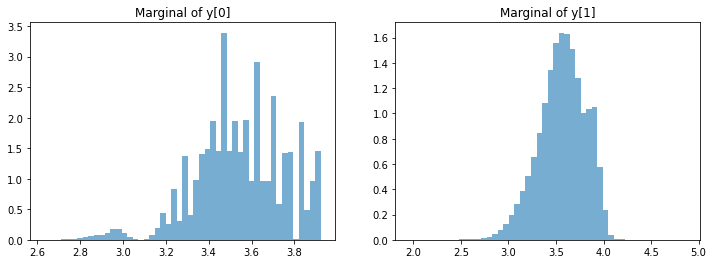

In [ ]:
import torch
import numpy as np

def monte_carlo_approximation_multivariate(
    model,
    X_test,
    n_mc_samples,
    mean_y,      # torch.Tensor or np.ndarray, shape (D,)
    std_y,       # torch.Tensor or np.ndarray, shape (D,)
    device='cpu'
):
    """
    Approximate the marginal f(y) by sampling from p(y|x) for each x ~ f(x).

    Args:
        model: a BNN whose forward(x) returns (mean, cov_matrix)
        X_test: array-like or Tensor of shape (N, input_dim)
        n_mc_samples: int, MC draws per x
        mean_y: (D,) vector for de-normalizing
        std_y:  (D,) vector for de-normalizing
        device: 'cpu' or 'cuda'

    Returns:
        y_samples: np.ndarray of shape (N * n_mc_samples, D)
    """
    model.to(device).eval()
    # ensure torch tensors
    if not torch.is_tensor(X_test):
        X = torch.tensor(X_test, dtype=torch.float32, device=device)
    else:
        X = X_test.to(device).float()

    all_samples = []

    with torch.no_grad():
        for x in X:
            # x: (input_dim,)
            x = x.unsqueeze(0)  # → (1, input_dim)
            mean, cov = model(x)           # mean: (1, D), cov: (1, D, D)
            mean = mean.squeeze(0)         # → (D,)
            cov  = cov .squeeze(0)         # → (D, D)

            # build MVN and sample
            mvn  = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
            draws = mvn.sample((n_mc_samples,))  # → (n_mc_samples, D)
            all_samples.append(draws.cpu().numpy())

    # (N, n_mc, D) → (N * n_mc, D)
    y_samples = np.vstack(all_samples)

    # de‐normalize (broadcast along first axis)
    # make sure mean_y/std_y are 1‐D arrays
    mean_y = np.asarray(mean_y).reshape(1, -1)
    std_y  = np.asarray(std_y ) .reshape(1, -1)
    y_samples = y_samples * std_y + mean_y

    return y_samples

# assuming std_y and mean_y are torch tensors of shape (2,)
std_y_np  = std_y
mean_y_np = mean_y

y_samples = monte_carlo_approximation_multivariate(
    model, X_test, n_mc_samples=5000,
    mean_y=mean_y_np, std_y=std_y_np, device=device
)

# Now `y_samples` is (N*300, 2). You can:
# - Plot marginal histograms:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12,4))
for d, ax in enumerate(axs):
    ax.hist(y_samples[:,d], bins=50, density=True, alpha=0.6)
    ax.set_title(f"Marginal of y[{d}]")
plt.show()



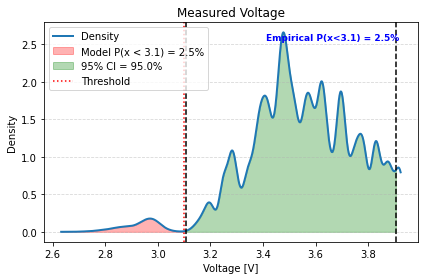

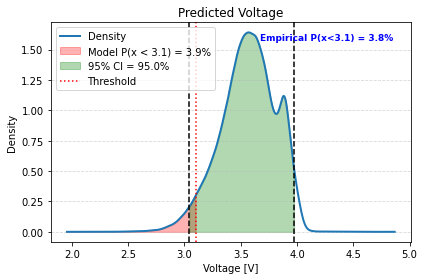

Empirical P(Measured < 3.1) = 2.50%
Empirical P(Predicted < 3.1) = 3.75%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming y_test, mean_y, std_y, and y_samples are already in the environment:
# Denormalize y_test
mean_y_np = mean_y.cpu().numpy().reshape(1, -1)
std_y_np = std_y.cpu().numpy().reshape(1, -1)
y_test_denorm = y_test.cpu().numpy() * std_y_np + mean_y_np

# Compute empirical failure probabilities
threshold = 3.1
p_true_meas = (y_test_denorm[:, 0] < threshold).mean() * 100
p_true_pred = (y_test_denorm[:, 1] < threshold).mean() * 100

# Modified plotting function to include empirical p_true
def plot_failure_with_empirical(y_samples, p_true, threshold, alpha_ci=0.95, title=""):
    kde = gaussian_kde(y_samples)
    xs = np.linspace(y_samples.min(), y_samples.max(), 1000)
    ys = kde(xs)

    lower_ci, upper_ci = np.percentile(
        y_samples,
        [(1 - alpha_ci) / 2 * 100, (1 + alpha_ci) / 2 * 100]
    )

    p_fail = np.mean(y_samples < threshold) * 100
    p_cov  = np.mean((y_samples >= lower_ci) & (y_samples <= upper_ci)) * 100

    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, lw=2, label='Density')
    plt.fill_between(xs[xs < threshold], ys[xs < threshold], color='red', alpha=0.3,
                     label=f'Model P(x < {threshold}) = {p_fail:.1f}%')
    plt.fill_between(xs[(xs>=lower_ci)&(xs<=upper_ci)], ys[(xs>=lower_ci)&(xs<=upper_ci)],
                     color='green', alpha=0.3, label=f'{int(alpha_ci*100)}% CI = {p_cov:.1f}%')
    plt.axvline(threshold, color='r', linestyle=':', label='Threshold')
    plt.axvline(lower_ci, color='k', linestyle='--')
    plt.axvline(upper_ci, color='k', linestyle='--')

    # Upper-right placement
    plt.text(0.95, 0.95,
             f'Empirical P(x<{threshold}) = {p_true:.1f}%',
             transform=plt.gca().transAxes,
             ha='right', va='top',
             color='blue', fontsize=9, weight='bold')

    plt.title(title)
    plt.xlabel("Voltage [V]")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Split samples
y_meas = y_samples[:, 0]
y_pred = y_samples[:, 1]

# Plot for Measured voltage
plot_failure_with_empirical(y_meas, p_true_meas, threshold, title="Measured Voltage")

# Plot for Predicted voltage
plot_failure_with_empirical(y_pred, p_true_pred, threshold, title="Predicted Voltage")

# Print empirical failure probabilities
print(f"Empirical P(Measured < {threshold}) = {p_true_meas:.2f}%")
print(f"Empirical P(Predicted < {threshold}) = {p_true_pred:.2f}%")


In [ ]:
import numpy as np
import torch
from scipy.stats import norm, rankdata
from numpy.linalg import pinv
import math
from torch.distributions import MultivariateNormal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ------------------------------
# Gaussian Copula Transformation Functions
# ------------------------------
def empirical_to_gaussian(X):
    """Transform empirical data to standard normal using ranks."""
    ranks = rankdata(X, axis=0)
    gaussian_vals = norm.ppf((ranks - 0.5) / len(X))
    return gaussian_vals

def empirical_to_gaussian_test(X, X_train):
    """Transform test instance X using the training data empirical distribution."""
    X_combined = np.vstack([X_train, X])
    ranks = rankdata(X_combined, axis=0)
    gaussian_vals = norm.ppf((ranks - 0.5) / len(X_combined))
    return gaussian_vals[-len(X):]

def inverse_empirical_cdf(X, quantiles):
    """Invert the empirical CDF of X at the given quantiles."""
    sorted_X = np.sort(X)
    return np.interp(quantiles, np.linspace(0, 1, len(X)), sorted_X)

# ------------------------------
# SHAP Kernel Matrix and R_D Calculation
# ------------------------------
def compute_k_matrix(M):
    W = np.zeros((2**M, 2**M))
    for i in range(2**M):
        subset_size = bin(i).count('1')
        if subset_size in [0, M]:
            W[i, i] = 0
        else:
            W[i, i] = (M - 1) / (math.comb(M, subset_size) * subset_size * (M - subset_size))
    return W

def compute_R_D(Z, W, num_samples, C=1e6):
    weights = np.diag(W)
    subset_indices = np.arange(1, Z.shape[0]-1)
    probabilities = weights[1:-1] / weights[1:-1].sum()
    sampled_indices = np.random.choice(subset_indices, num_samples, p=probabilities)
    sampled_indices = np.concatenate(([0], sampled_indices, [Z.shape[0]-1]))
    Z_D = Z[sampled_indices, :]
    W_D = np.diag(W[sampled_indices, sampled_indices])
    W_D[0, 0] = W_D[-1, -1] = C
    R_D = pinv(Z_D.T @ W_D @ Z_D) @ Z_D.T @ W_D
    return R_D, sampled_indices

# ------------------------------
# Reliability: Separate Failure Probability Evaluation with De-normalization
# ------------------------------
def probability_false_neg_pos( model, X_input, threshold=(3.2, 3.2), n_mc=25, n_inner=25, target_mean=None, target_std=None, return_per_sample=False):
    """
    Vectorized evaluation of False-Neg and False-Pos rates.
    If return_per_sample=False → returns [P_FN, P_FP] averaged over X_input.
    If return_per_sample=True  → returns array shape (n_input, 2).
    """
    device = X_input.device
    n = X_input.shape[0]

    # Accumulators for each sample in the batch
    fn_accum = torch.zeros(n, device=device)
    fp_accum = torch.zeros(n, device=device)

    for _ in range(n_mc):
        # 1) One forward pass for the whole batch
        mean, cov = model(X_input)  
        # cov: (batch, 2, 2), mean: (batch, 2)

        # 2) Build a batched MultivariateNormal over the batch
        cov = cov + 1e-6 * torch.eye(mean.size(-1), device=device).unsqueeze(0)
        dist = MultivariateNormal(loc=mean, covariance_matrix=cov)

        # 3) Sample n_inner draws **all at once**: shape (n_inner, batch, 2)
        samples = dist.rsample((n_inner,))

        # 4) De-normalize if needed (also vectorized)
        if target_mean is not None and target_std is not None:
            # Make sure these are torch tensors on the right device/dtype:
            mean_t = torch.as_tensor(target_mean, device=device, dtype=samples.dtype)  # shape (2,)
            std_t  = torch.as_tensor(target_std,  device=device, dtype=samples.dtype)  # shape (2,)
            # Now broadcast multiply/add over the last dim:
            samples = samples * std_t + mean_t  # samples stays shape (n_inner, batch, 2)



        # 5) Split into meas/pred arrays: both (n_inner, batch)
        meas = samples[..., 0]
        pred = samples[..., 1]

        # 6) Compute FN/FP rates **along the n_inner axis** → shape (batch,)
        fn_batch = ((meas < threshold[0]) & (pred >= threshold[1])).float().mean(dim=0)
        fp_batch = ((meas >= threshold[0]) & (pred < threshold[1])).float().mean(dim=0)

        fn_accum += fn_batch
        fp_accum += fp_batch

    # 7) Average over the MC dimension
    fn_rate = fn_accum / n_mc  # (batch,)
    fp_rate = fp_accum / n_mc  # (batch,)

    if return_per_sample:
        # return per-input FN/FP
        return torch.stack([fn_rate, fp_rate], dim=1).cpu().numpy()
    else:
        # return the overall means
        return np.array([fn_rate.mean().item(), fp_rate.mean().item()])


# ------------------------------
# Compute Conditional Failure Probability v(S) for a Given Subset S
# ------------------------------
def compute_v_S_combined_reliability(X_test_instance, X_train_tensor, subset_S, subset_S_complement, model, threshold=(3.2, 3.2), K=50, sigma=0.1, D_star=3, target_mean=None, target_std=None, n_mc=25, n_inner=25, device='cuda'):
    """
    Compute the conditional failure probabilities P(Y_i < threshold_i) for i=1,2
    by "fixing" the features in subset_S to the test instance and sampling the remaining features conditionally.
    
    Returns a two-element vector: [p_failure_target1, p_failure_target2].
    """
    X_train_np = X_train_tensor.cpu().numpy()
    X_test_np = X_test_instance.cpu().numpy().flatten()
    M = X_train_np.shape[1]
    
    # Case 1: All features provided (nothing to sample)
    # Case 1: All features known
    if len(subset_S_complement) == 0:
        # replicate the test instance K times
        X_rep = X_test_instance.repeat(K, 1).to(device)  # (K, M)
        return probability_false_neg_pos(model, X_rep, threshold, n_mc=n_mc, n_inner=n_inner, target_mean=target_mean, target_std=target_std)
    
    # Case 2: No features provided: sample K training instances.
    if len(subset_S) == 0:
        indices = np.random.choice(len(X_train_tensor), K, replace=False)
        X_samples = X_train_tensor[indices].to(device)
        p_fail = probability_false_neg_pos(model, X_samples, threshold, n_mc=n_mc, n_inner=n_inner, target_mean=target_mean, target_std=target_std)
        return p_fail
    
    # Case 3: Small subset S (empirical sampling via nearest neighbors)
    if len(subset_S) <= D_star:
        # compute Euclidean distances on S
        dists = np.linalg.norm(X_test_np[subset_S] - X_train_np[:, subset_S], axis=1)
        weights = np.exp(-dists**2 / (2 * sigma**2))
        top_K = np.argsort(weights)[-K:]
        wK = weights[top_K]
        w_norm = wK / wK.sum()

        # build mixed inputs
        X_samp = X_train_tensor[top_K][:, subset_S_complement].to(device)
        X_mix = torch.zeros((K, M), device=device)
        X_mix[:, subset_S] = X_test_instance[:, subset_S].repeat(K, 1)
        X_mix[:, subset_S_complement] = X_samp
        # evaluate each neighbor, then weighted sum
        p_arr = probability_false_neg_pos(
            model, X_mix, threshold,
            n_mc=n_mc, n_inner=n_inner,
            target_mean=target_mean, target_std=target_std,
            return_per_sample=True)
        return (w_norm[:, None] * p_arr).sum(axis=0)
        
    else:
        # Case 4: Use Gaussian copula to conditionally sample the missing features.
        V = empirical_to_gaussian(X_train_np)
        mu = V.mean(0)
        Sigma = np.cov(V, rowvar=False)
        mu_S = mu[subset_S]
        mu_Sc = mu[subset_S_complement]
        Sigma_SS = Sigma[np.ix_(subset_S, subset_S)]
        Sigma_ScS = Sigma[np.ix_(subset_S_complement, subset_S)]
        Sigma_ScSc = Sigma[np.ix_(subset_S_complement, subset_S_complement)]
        # Transform test instance to Gaussian space.
        v_star = empirical_to_gaussian_test(X_test_np.reshape(1, -1), X_train_np)[0]
        v_star_S = v_star[subset_S]
        cov_inv_SS = np.linalg.pinv(Sigma_SS + 1e-6 * np.eye(len(subset_S)))
        conditional_mu = mu_Sc + Sigma_ScS @ cov_inv_SS @ (v_star_S - mu_S)
        conditional_cov = Sigma_ScSc - Sigma_ScS @ cov_inv_SS @ Sigma_ScS.T + 1e-6 * np.eye(len(subset_S_complement))
        V_samples = np.random.multivariate_normal(conditional_mu, conditional_cov, K)
        U_samples = norm.cdf(V_samples)
        X_samples = np.zeros((K, M))
        for idx, j in enumerate(subset_S_complement):
            X_samples[:, j] = inverse_empirical_cdf(X_train_np[:, j], U_samples[:, idx])
        X_samples[:, subset_S] = X_test_np[subset_S]
        X_test_pred = torch.tensor(X_samples).float().to(device)
    
        # Evaluate the constructed samples using the model.
        p_fail = probability_false_neg_pos( model, X_test_pred, threshold, n_mc=n_mc, n_inner=n_inner, target_mean=target_mean, target_std=target_std)
        return p_fail

# ------------------------------
# KernelSHAP Aggregation for Reliability Analysis
# ------------------------------
def kernel_shap_all_reliability(X_test_tensor, X_train_tensor, model, num_samples=500, D_star=3,
                                threshold=(3.2, 3.2), target_mean=None, target_std=None, device='cuda'):
    """
    For each test instance, compute the conditional failure probabilities (for both targets)
    for many feature subsets and then aggregate them using the KernelSHAP approach.
    
    Returns an array of Shapley values with shape (n_test, 2), where each row contains
    the attribution for each target's failure probability.
    """
    M = X_train_tensor.shape[1]
    num_subsets = 2**M
    Z = np.ones((num_subsets, M+1))
    for i in range(num_subsets):
        Z[i, 1:] = list(map(int, format(i, f'0{M}b')))
    
    W_matrix = compute_k_matrix(M)
    R_D, sampled_indices = compute_R_D(Z, W_matrix, num_samples)
    
    shap_values_all = []
    for i in range(X_test_tensor.shape[0]):
    #for i in range(20):
        print(f"\n--- Processing test instance {i} ---")
        X_test_instance = X_test_tensor[i, :].unsqueeze(0)
        p_fail_values = []
        
        for idx in sampled_indices:
            subset_S = np.where(Z[idx, 1:] == 1)[0].tolist()
            subset_S_complement = [j for j in range(M) if j not in subset_S]
            p_fail = compute_v_S_combined_reliability( X_test_instance, X_train_tensor, subset_S, subset_S_complement, model, threshold=threshold, K=100, sigma=0.1, D_star=D_star, target_mean=target_mean, target_std=target_std, n_mc=25, n_inner=25, device=device)
            p_fail_values.append(p_fail)
        
        instance_shap = R_D @ np.vstack(p_fail_values)
        #instance_shap = R_D @ np.array(p_fail_values)
        shap_values_all.append(instance_shap)
    
    return np.stack(shap_values_all, axis=0)

# Compute reliability-oriented SHAP values (separate failure probability contributions)
# For demonstration, we use num_samples=20 for the KernelSHAP weight computation.

#X_all = torch.cat([X_train, X_test], dim=0)

shap_fn_fp = kernel_shap_all_reliability(X_test, X_train, model, num_samples=512, D_star=3, threshold=(3.2, 3.2), target_mean=mean_y, target_std=std_y, device=device)

print("\nReliability-oriented SHAP values (separate failure probability contributions):")
print(shap_fn_fp)



--- Processing test instance 0 ---


KeyboardInterrupt: 

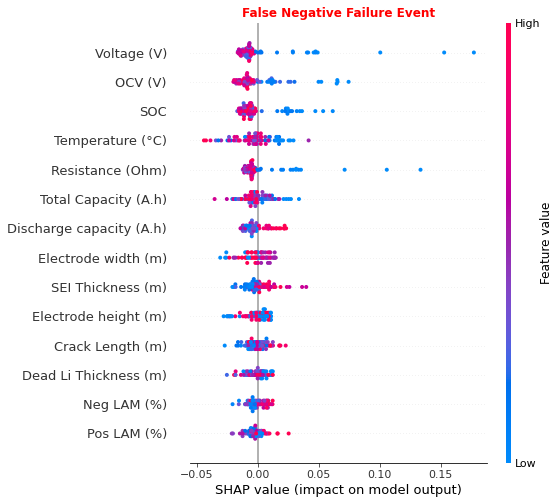

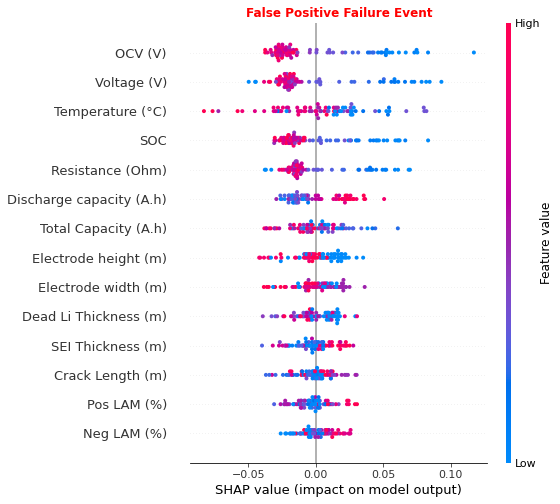

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume you have:
#   shap_fn_fp      : NumPy array of shape (n_test, M+1, 2)
#   X_test_tensor   : torch.Tensor of shape (n_test, M)
#   feature_names   : list of length M with your feature names

# Convert tensors/arrays
shap_arr = shap_fn_fp        # (n_test, M+1, 2), index 0 is the bias term
X_test_np = X_test.cpu().numpy()  # (n_test, M)

# Drop the bias column (index 0) and select each target
shap_values_fn = shap_arr[:, 1:, 0]  # SHAP values for False Negative rate
shap_values_fp = shap_arr[:, 1:, 1]  # SHAP values for False Positive rate

# If you don't have custom feature names, generate generic ones:
#feature_names = [f"Feature {i+1}" for i in range(shap_values_fn.shape[1])]

df = pd.read_excel(file_path)
feature_names = df.columns.tolist()[:-2]

# --- False Negative summary plot ---
shap.summary_plot(
    shap_values_fn,
    X_test_np,
    feature_names=feature_names,
    plot_type="dot",
    show=False       # prevent it from immediately calling plt.show()
)
plt.title("False Negative Failure Event", fontweight="bold", color="red",)
plt.tight_layout()
plt.show()

# False Positive summary
shap.summary_plot(
    shap_values_fp,
    X_test_np,
    feature_names=feature_names,
    plot_type="dot",
    show=False
)
plt.title("False Positive Failure Event", fontweight="bold", color="red",)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm, rankdata
from numpy.linalg import pinv, inv
import math

np.random.seed(0)  # Set the seed for NumPy functions
torch.manual_seed(0)  # Set the seed for PyTorch functions

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)  # For all GPUs, if your computation involves GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SHAP Kernel Matrix
def compute_k_matrix(M):
    W = np.zeros((2**M, 2**M))
    for i in range(2**M):
        subset_size = bin(i).count('1')
        if subset_size in [0, M]:
            W[i, i] = 0
        else:
            W[i, i] = (M - 1) / (math.comb(M, subset_size) * subset_size * (M - subset_size))
    return W

# Compute R_D matrix
def compute_R_D(Z, W, num_samples, C=1e6):
    weights = np.diag(W)
    subset_indices = np.arange(1, Z.shape[0]-1)
    probabilities = weights[1:-1] / weights[1:-1].sum()
    sampled_indices = np.random.choice(subset_indices, num_samples, p=probabilities)
    sampled_indices = np.concatenate(([0], sampled_indices, [Z.shape[0]-1]))
    Z_D = Z[sampled_indices, :]
    W_D = np.diag(W[sampled_indices, sampled_indices])
    W_D[0, 0] = W_D[-1, -1] = C
    R_D = pinv(Z_D.T @ W_D @ Z_D) @ Z_D.T @ W_D
    return R_D, sampled_indices

# Gaussian copula transformations
def empirical_to_gaussian(X):
    ranks = rankdata(X, axis=0)  # Handles ties properly
    gaussian_vals = norm.ppf((ranks - 0.5) / len(X))  # Uniform to Gaussian
    return gaussian_vals

def empirical_to_gaussian_test(X, X_train):
    X_combined = np.vstack([X_train, X])  # Stack test instance with training data
    ranks = rankdata(X_combined, axis=0)  # Compute ranks over full dataset
    gaussian_vals = norm.ppf((ranks - 0.5) / len(X_combined))  # Normal transformation
    return gaussian_vals[-len(X):]  # Extract transformed test samples

def inverse_empirical_cdf(X, quantiles):
    sorted_X = np.sort(X)
    interpolate = np.interp(quantiles, np.linspace(0, 1, len(X)), sorted_X)
    return interpolate

def compute_v_S_combined(X_test_instance, X_train_tensor, subset_S, subset_S_complement,
                         model, K=200, sigma=0.1, D_star=3, device='cuda'):
    X_train_np = X_train_tensor.cpu().numpy()
    X_test_np = X_test_instance.cpu().numpy().flatten()
    M = X_train_np.shape[1]
    
    # Case 1: When all features are provided (subset_S_complement is empty)
    if len(subset_S_complement) == 0:
        # Repeat the single test instance K times
        X_rep = X_test_instance.repeat(K, 1).to(device)   # shape (K, M)
        with torch.no_grad():
            y_means, covs = model(X_rep)                  # y_means: (K, 2), covs: (K, 2, 2)
        # Average across the K Monte Carlo samples
        mean_val = y_means.cpu().numpy().mean(axis=0)     # shape (2,)
        full_var  = covs.cpu().numpy().mean(axis=0)        # shape (2, 2)
        var_val  = np.diag(full_var)
        return mean_val, var_val

    # Case 2: When no features are provided (subset_S is empty)
    if len(subset_S) == 0:
        indices = np.random.choice(len(X_train_tensor), K, replace=False)
        X_samples = X_train_tensor[indices].to(device)
        with torch.no_grad():
            y_mean, cov_matrix = model(X_samples)
        mean_val = y_mean.cpu().detach().numpy().mean(axis=0)
        full_var = cov_matrix.cpu().detach().numpy().mean(axis=0)
        var_val  = np.diag(full_var)
        return mean_val, var_val

    # Case 3: When subset_S is small (empirical method)
    if len(subset_S) <= D_star:
        # 1) Estimate Σ_S and its inverse
        cov_S = np.atleast_2d(
            np.cov(X_train_np[:, subset_S], rowvar=False)
        ) + 1e-6 * np.eye(len(subset_S))
        cov_inv_S = pinv(cov_S)
        
        # 2) Mahalanobis distances on S
        distances = np.array([mahalanobis(X_test_np[subset_S], X_train_np[i, subset_S], cov_inv_S) for i in range(len(X_train_np))])
    
        # 3) Kernel weights
        weights = np.exp(-distances**2 / (2 * sigma**2))          # shape (n_train,)
        top_K_indices = np.argsort(weights)[-K:]                  # pick top-K
        w_K = weights[top_K_indices]
        w_norm = w_K / w_K.sum()                                  # normalized weights (sum to 1)
        
        # 4) Build “mixed” inputs: fix S from x*, fill S̄ from top‐K neighbors
        X_samples = X_train_tensor[top_K_indices][:, subset_S_complement].to(device)
        X_test_pred = torch.zeros((K, M), device=device)
        # held‐in features
        X_test_pred[:, subset_S] = X_test_instance[:, subset_S].repeat(K, 1)
        # sampled‐out features
        X_test_pred[:, subset_S_complement] = X_samples
        
        # 5) Forward through the BNN
        with torch.no_grad():
            y_means, covs = model(X_test_pred)                    # (K,2), (K,2,2)
        
        # 6) Weighted average of outputs
        m_np = y_means.cpu().numpy()                             # (K,2)
        c_np = covs.cpu().numpy()                                # (K,2,2)
        mean_val = (w_norm[:, None] * m_np).sum(axis=0)          # (2,)
        full_var  = (w_norm[:, None, None] * c_np).sum(axis=0)    # (2,2)
        var_val  = np.diag(full_var)
        
        return mean_val, var_val


    # Case 4: When subset_S is larger (Gaussian copula method)
    else:
        V = empirical_to_gaussian(X_train_np)
        mu, Sigma = V.mean(0), np.cov(V, rowvar=False)
        mu_S, mu_Sc = mu[subset_S], mu[subset_S_complement]
        Sigma_SS = Sigma[np.ix_(subset_S, subset_S)]
        Sigma_ScS = Sigma[np.ix_(subset_S_complement, subset_S)]
        Sigma_ScSc = Sigma[np.ix_(subset_S_complement, subset_S_complement)]
        v_star_S = empirical_to_gaussian_test(X_test_np.reshape(1, -1), X_train_np)[0, subset_S]
        cov_inv_SS = np.linalg.pinv(Sigma_SS + 1e-6 * np.eye(len(subset_S)))
        conditional_mu = mu_Sc + Sigma_ScS @ cov_inv_SS @ (v_star_S - mu_S)
        conditional_cov = Sigma_ScSc - Sigma_ScS @ cov_inv_SS @ Sigma_ScS.T + 1e-6 * np.eye(len(subset_S_complement))
        V_samples = np.random.multivariate_normal(conditional_mu, conditional_cov, K)
        U_samples = norm.cdf(V_samples)
        X_samples = np.zeros((K, M))
        for idx, j in enumerate(subset_S_complement):
            X_samples[:, j] = inverse_empirical_cdf(X_train_np[:, j], U_samples[:, idx])
        X_samples[:, subset_S] = X_test_np[subset_S]
        X_test_pred = torch.tensor(X_samples).float().to(device)

        # Evaluate the model on the constructed X_test_pred.
        with torch.no_grad():
            y_mean, cov_matrix = model(X_test_pred)  # Directly get cov_matrix (variance)
        final_mean = y_mean.cpu().detach().numpy().mean(axis=0)
        full_var  = cov_matrix.cpu().detach().numpy().mean(axis=0)   # shape (2,2)
        var_val  = np.diag(full_var)
        
        return final_mean, var_val


def kernel_shap_all_mean_var(X_test_tensor, X_train_tensor, model, num_samples=1024, D_star=3, device='cuda'):
    M = X_train_tensor.shape[1]
    num_subsets = 2**M
    Z = np.ones((num_subsets, M+1))
    for i in range(num_subsets):
        Z[i, 1:] = list(map(int, format(i, f'0{M}b')))
    
    #print('Z matrix: \n', Z)
    W_matrix = compute_k_matrix(M)
    R_D, sampled_indices = compute_R_D(Z, W_matrix, num_samples)
    
    shap_mean_all, shap_var_all = [], []

    for i in range(X_test_tensor.shape[0]):
    #for i in range(2):
        print(f"\n--- Processing test instance {i} ---")
        X_test_instance = X_test_tensor[i, :].unsqueeze(0)
        v_S_mean_values, v_S_var_values = [], []

        for idx in sampled_indices:
            
            subset_S = np.where(Z[idx, 1:] == 1)[0].tolist()
            #print(subset_S)
            subset_S_complement = [j for j in range(M) if j not in subset_S]
            
            v_mean, v_var = compute_v_S_combined(
                X_test_instance, X_train_tensor, subset_S, subset_S_complement,
                model, D_star=D_star, device=device
            )
            #print(v_mean.shape)
            v_S_mean_values.append(v_mean)
            v_S_var_values.append(v_var)

        #print(f"R_D shape: {R_D.shape}, , v_S_mean_values shape : {np.array(v_S_mean_values).shape}, v_S_var_values shape: {np.array(v_S_var_values).shape}")

        instance_shap_mean = R_D @ np.array(v_S_mean_values)
        instance_shap_var = R_D @ np.array(v_S_var_values)
        
        shap_mean_all.append(instance_shap_mean)
        shap_var_all.append(instance_shap_var)

    return np.array(shap_mean_all), np.array(shap_var_all)

#X_all = torch.cat([X_train, X_test], dim=0)

shap_values_all_mean, shap_values_all_var = kernel_shap_all_mean_var(X_test, X_train, model, device=device)



--- Processing test instance 0 ---

--- Processing test instance 1 ---

--- Processing test instance 2 ---

--- Processing test instance 3 ---

--- Processing test instance 4 ---

--- Processing test instance 5 ---

--- Processing test instance 6 ---

--- Processing test instance 7 ---

--- Processing test instance 8 ---

--- Processing test instance 9 ---

--- Processing test instance 10 ---

--- Processing test instance 11 ---

--- Processing test instance 12 ---

--- Processing test instance 13 ---

--- Processing test instance 14 ---

--- Processing test instance 15 ---

--- Processing test instance 16 ---

--- Processing test instance 17 ---

--- Processing test instance 18 ---

--- Processing test instance 19 ---

--- Processing test instance 20 ---

--- Processing test instance 21 ---

--- Processing test instance 22 ---

--- Processing test instance 23 ---

--- Processing test instance 24 ---

--- Processing test instance 25 ---

--- Processing test instance 26 ---

--- Proces

KeyboardInterrupt: 

In [ ]:
print(shap_values_all_mean.shape)

(80, 15, 2)


shap_mean_arr shape: (80, 15, 2)
shap_var_arr shape: (80, 15, 2)
X_test_np shape: (80, 14)


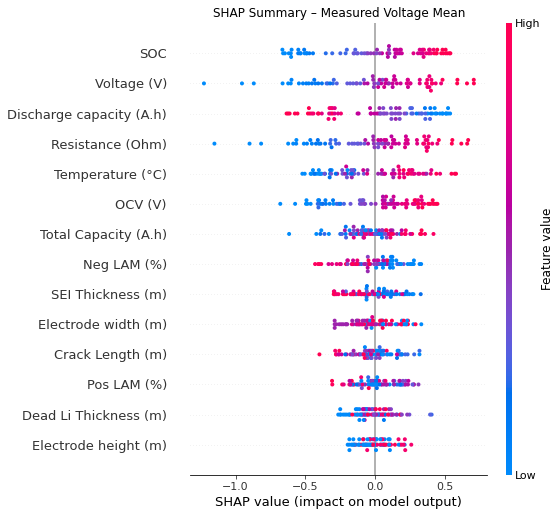

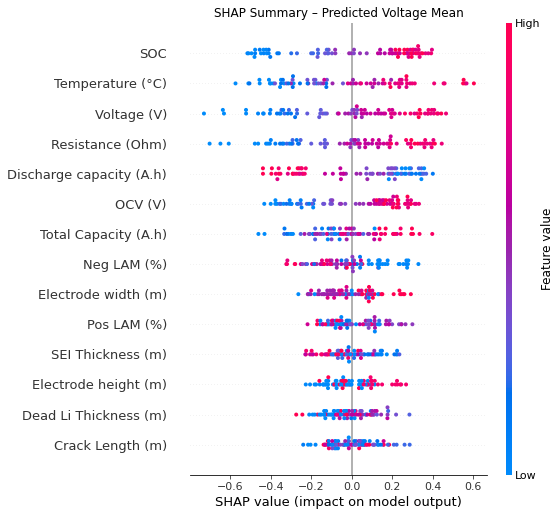

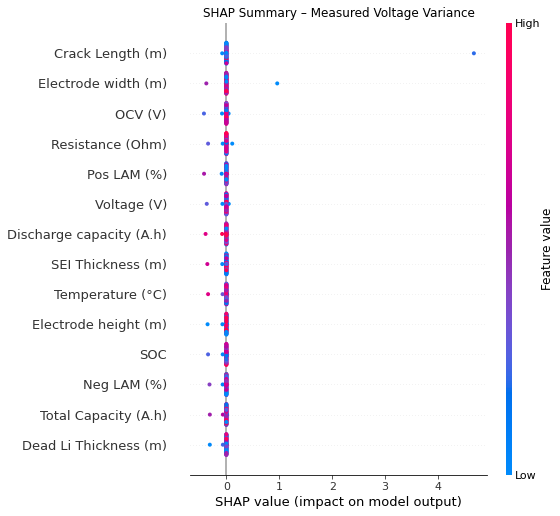

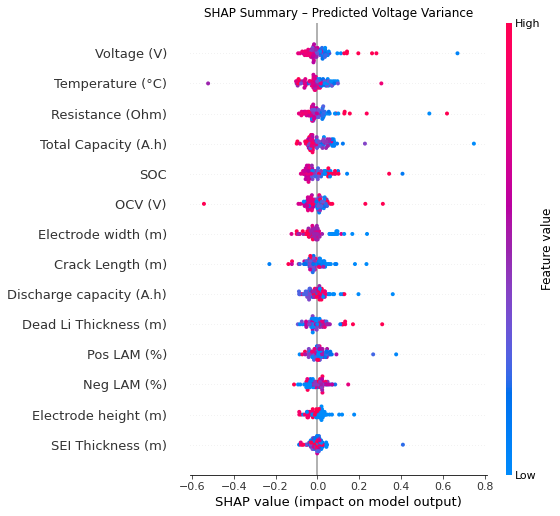

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import torch
import pandas as pd

# ========================================
# 1. Convert Nested SHAP Lists to NumPy Arrays
# ========================================

# Now each elem in shap_values_all_var is already shape (1,2) → squeeze → (2,)
shap_mean_arr = np.array([[elem.squeeze() for elem in row]
                          for row in shap_values_all_mean])
print("shap_mean_arr shape:", shap_mean_arr.shape)
# → (n_test, M+1, 2)

shap_var_arr = np.array([[elem.squeeze() for elem in row]
                         for row in shap_values_all_var])
print("shap_var_arr shape:", shap_var_arr.shape)
# → (n_test, M+1, 2)

# ========================================
# 2. Exclude the Bias Column
# ========================================
# Drop the first column (the “bias” term)
shap_mean_no_bias = shap_mean_arr[:, 1:, :]   # → (n_test, M, 2)
shap_var_no_bias  = shap_var_arr[:, 1:, :]    # → (n_test, M, 2)

# ========================================
# 3. Split into Measured vs Predicted
# ========================================
measured_mean  = shap_mean_no_bias[:, :, 0]    # (n_test, M)
predicted_mean = shap_mean_no_bias[:, :, 1]    # (n_test, M)

measured_var   = shap_var_no_bias[:, :, 0]     # (n_test, M)
predicted_var  = shap_var_no_bias[:, :, 1]     # (n_test, M)

# ========================================
# 4. Get feature values for those n_test cases
# ========================================
# Assuming X_test is a tensor, and n_test = shap_values_all_mean.shape[0]
n_test = shap_mean_arr.shape[0]
X_test_np = X_test[:n_test].cpu().numpy()      # → (n_test, M)
print("X_test_np shape:", X_test_np.shape)

# ========================================
# 5. Load feature names
# ========================================
df = pd.read_excel(file_path)
feature_names = df.columns.tolist()[:-2]        # drop last two target columns

# ========================================
# 6. SHAP Summary Plots
# ========================================
plt.figure(figsize=(12, 6))
shap.summary_plot(measured_mean, features=X_test_np, feature_names=feature_names, show=False)
plt.title("SHAP Summary – Measured Voltage Mean")
plt.show()

plt.figure(figsize=(12, 6))
shap.summary_plot(predicted_mean, features=X_test_np, feature_names=feature_names, show=False)
plt.title("SHAP Summary – Predicted Voltage Mean")
plt.show()

plt.figure(figsize=(12, 6))
shap.summary_plot(measured_var, features=X_test_np, feature_names=feature_names, show=False)
plt.title("SHAP Summary – Measured Voltage Variance")
plt.show()

plt.figure(figsize=(12, 6))
shap.summary_plot(predicted_var, features=X_test_np, feature_names=feature_names, show=False)
plt.title("SHAP Summary – Predicted Voltage Variance")
plt.show()
